In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import gc
import importlib as imp

# custom module for capstone 2
import cap2tools as c2t
imp.reload(c2t)

Using TensorFlow backend.


<module 'cap2tools' from 'C:\\Users\\Nils\\Documents\\GitHub\\Springboard-Capstone-2-local-yelp\\cap2tools.py'>

In [2]:
def run_in_replicate(width, name, n_models=2, n_epochs=10, new_weights=False, trainable=False, 
                     learning_rate=0.0001, dropout1=0, dropout2=0):
    '''
    Runs two initialization and training passes for each model variation
    
    Returns the training history
    '''
    from datetime import datetime
    from keras.callbacks import ModelCheckpoint
    
    filename = 'vgg16_{}_'.format(str(name))
    
    histories = []
    
    for idx in range(1, n_models+1):
        datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print('{} - Starting training for {}'.format(datetime_now, filename + str(idx)))

        # define callback for model saving
        checkpointer = ModelCheckpoint(filename + str(idx) + '.h5', 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=True)

        # build and train model
        model = c2t.build_VGG16(width, new_weights=new_weights, trainable=trainable, 
                                learning_rate=learning_rate, dropout1=dropout1, 
                                dropout2=dropout2)
        hist = model.fit_generator(train_batches,
                                   validation_data=valid_batches,
                                   epochs=n_epochs, 
                                   callbacks=[checkpointer], 
                                   verbose=0)
        histories.append(hist)
        
        # remove clutter from memory
        del model
        K.clear_session()
        
    def avg_metric(metric):
        average_metric = np.array(histories[0].history[metric])
        
        for idx in range(1, len(histories)):
            average_metric += np.array(histories[idx].history[metric])
            
        return average_metric/len(histories)
    
    # determine average metrics of the two runs
    acc = avg_metric('acc')
    loss = avg_metric('loss')
    val_acc = avg_metric('val_acc')
    val_loss = avg_metric('val_loss')
    
    # plot loss history
    plot_df = tuple([loss, val_loss])
    plot_df = np.column_stack(plot_df)
    plot_df = pd.DataFrame(plot_df, columns=('training', 'validation'))
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_df.plot(ax=ax)
    plt.title('Loss over epochs: {}'.format(filename))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, len(loss)))
    plt.legend(loc='upper right')
    plt.show()
    
    return {'acc': acc, 'loss':loss, 'val_acc':val_acc, 'val_loss':val_loss}

In [3]:
# configure GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

In [4]:
# define paths to image directories
train_path = 'sampled_photos/train'
valid_path = 'sampled_photos/val'

# build image generators to feed CNN
train_batches, valid_batches = c2t.build_data_gens([train_path, valid_path])

Found 9000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [1]:
# test different conditions for model
d2s = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

histories = dict()

for d2 in d2s:
    name = 'dropout2_{}'.format(str(d2).replace('.', '-')) 
    histories[d2] = run_in_replicate(width=800, 
                                     name=name,
                                     n_models=2,
                                     n_epochs=10, 
                                     new_weights=False, 
                                     trainable=True,
                                     dropout2=d2)

NameError: name 'c2t' is not defined

In [ ]:
# save history as json
hist_path = 'VGG16_dropout2_comparison_history.json'
pd.DataFrame(histories).transpose().to_json(hist_path)

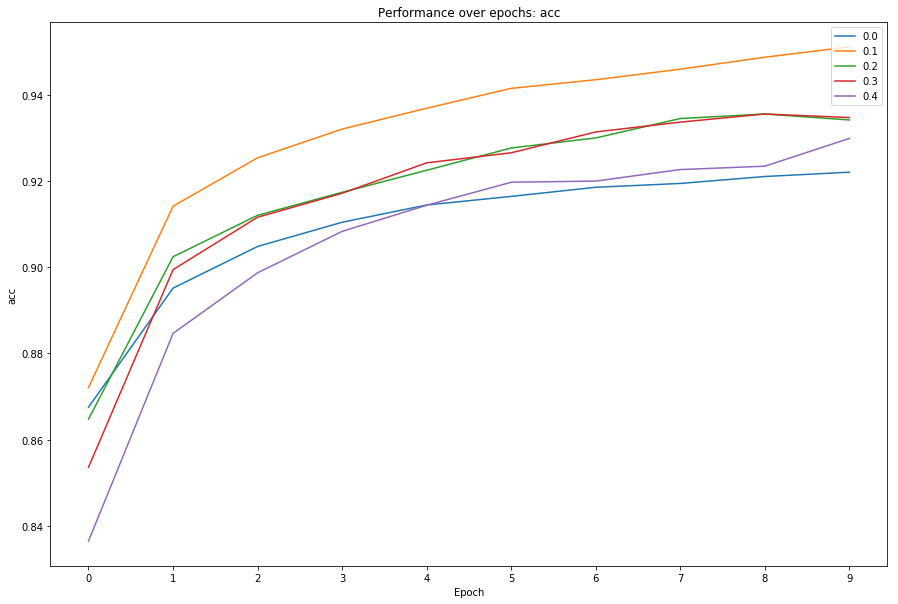

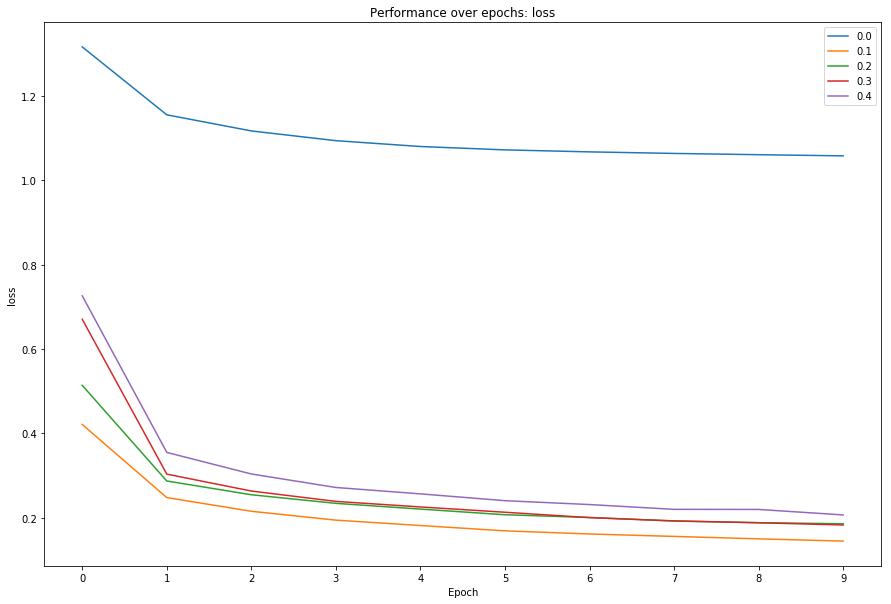

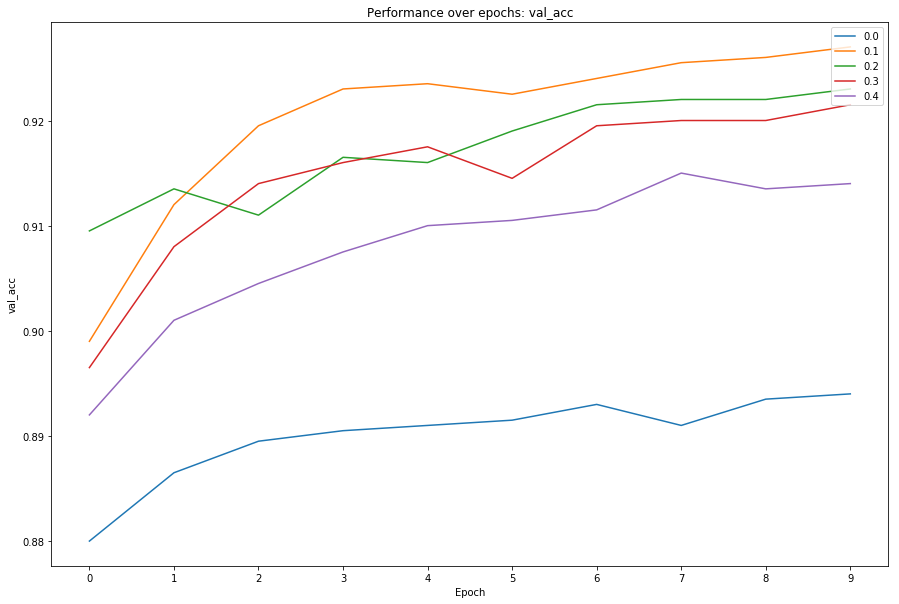

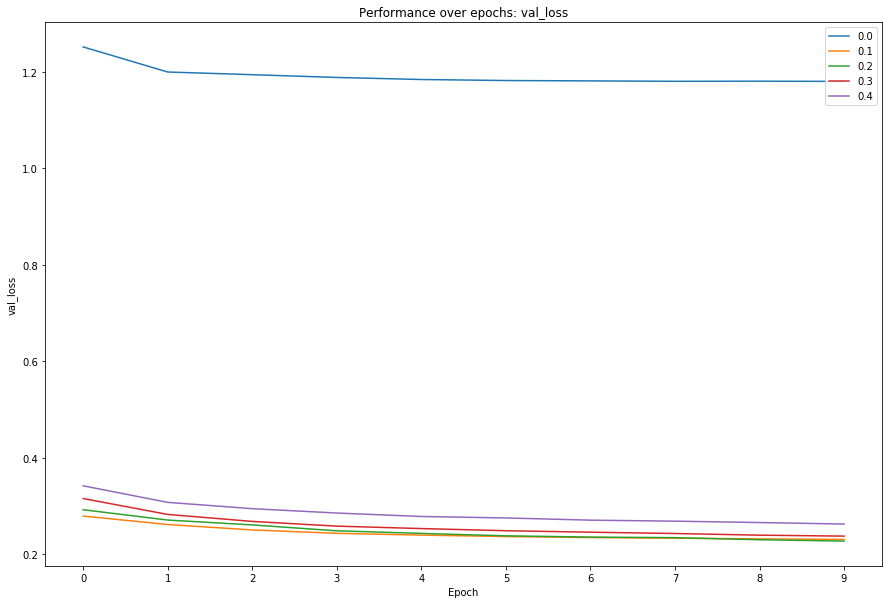

In [3]:
# load history from json
hist_path = 'VGG16_dropout2_comparison_history.json'
histories_load = pd.read_json(hist_path, convert_axes=False)

# drop conditions with poor performance
histories_load.drop(['0.5'], inplace=True)

# plot history comparisons
c2t.plot_metric('acc', histories_load)
c2t.plot_metric('loss', histories_load)
c2t.plot_metric('val_acc', histories_load)
c2t.plot_metric('val_loss', histories_load)

In [18]:
# evaluate trained models on validation dataset
data_path = 'sampled_photos/val'

model_paths = {'0 - 1':'vgg16_dropout2_0_1.h5', 
               '0 - 2':'vgg16_dropout2_0_2.h5',
               '0.1 - 1':'vgg16_dropout2_0-1_1.h5', 
               '0.1 - 2':'vgg16_dropout2_0-1_2.h5', 
               '0.2 - 1':'vgg16_dropout2_0-2_1.h5', 
               '0.2 - 2':'vgg16_dropout2_0-2_2.h5',
               '0.3 - 1':'vgg16_dropout2_0-3_1.h5', 
               '0.3 - 2':'vgg16_dropout2_0-3_2.h5',
               '0.4 - 1':'vgg16_dropout2_0-4_1.h5', 
               '0.4 - 2':'vgg16_dropout2_0-4_2.h5',
               '0.5 - 1':'vgg16_dropout2_0-5_1.h5', 
               '0.5 - 2':'vgg16_dropout2_0-5_2.h5'}

model_metrics = c2t.eval_models(model_paths, data_path)

Building image generator...
Found 1000 images belonging to 5 classes.
Loading model vgg16_dropout2_0_1.h5
Evaluating model vgg16_dropout2_0_1.h5
Loading model vgg16_dropout2_0_2.h5
Evaluating model vgg16_dropout2_0_2.h5
Loading model vgg16_dropout2_0-1_1.h5
Evaluating model vgg16_dropout2_0-1_1.h5
Loading model vgg16_dropout2_0-1_2.h5
Evaluating model vgg16_dropout2_0-1_2.h5
Loading model vgg16_dropout2_0-2_1.h5
Evaluating model vgg16_dropout2_0-2_1.h5
Loading model vgg16_dropout2_0-2_2.h5
Evaluating model vgg16_dropout2_0-2_2.h5
Loading model vgg16_dropout2_0-3_1.h5
Evaluating model vgg16_dropout2_0-3_1.h5
Loading model vgg16_dropout2_0-3_2.h5
Evaluating model vgg16_dropout2_0-3_2.h5
Loading model vgg16_dropout2_0-4_1.h5
Evaluating model vgg16_dropout2_0-4_1.h5
Loading model vgg16_dropout2_0-4_2.h5
Evaluating model vgg16_dropout2_0-4_2.h5
Loading model vgg16_dropout2_0-5_1.h5
Evaluating model vgg16_dropout2_0-5_1.h5
Loading model vgg16_dropout2_0-5_2.h5
Evaluating model vgg16_dropout2

In [19]:
# create table of evaluation results
table = c2t.eval_table(model_metrics, 'Dropout2', decimals=3)
table

,acc,loss,mpcr
Dropout2,,,
0 - 1,0.865,2.096,0.387
0 - 2,0.923,0.264,0.646
0.1 - 1,0.926,0.248,0.624
0.1 - 2,0.928,0.213,0.674
0.2 - 1,0.924,0.213,0.617
0.2 - 2,0.922,0.241,0.572
0.3 - 1,0.907,0.270,0.530
0.3 - 2,0.936,0.205,0.664
0.4 - 1,0.931,0.240,0.668


In [20]:
model_metrics

{'0 - 1': {'loss': 2.095582862489035,
  'acc': 0.865,
  'cm': [[0, 21, 8, 0, 0],
   [0, 657, 5, 0, 0],
   [0, 13, 208, 0, 0],
   [0, 0, 3, 0, 0],
   [0, 3, 82, 0, 0]],
  'mpcr': 0.3867247200995202},
 '0 - 2': {'loss': 0.26375763314333744,
  'acc': 0.923,
  'cm': [[19, 6, 4, 0, 0],
   [5, 649, 7, 0, 1],
   [2, 11, 194, 0, 14],
   [0, 0, 1, 0, 2],
   [0, 1, 23, 0, 61]],
  'mpcr': 0.6462020129359252},
 '0.1 - 1': {'loss': 0.2482477831815195,
  'acc': 0.926,
  'cm': [[15, 8, 6, 0, 0],
   [3, 650, 7, 0, 2],
   [4, 7, 200, 0, 10],
   [0, 0, 2, 0, 1],
   [0, 0, 24, 0, 61]],
  'mpcr': 0.6243477850963925},
 '0.1 - 2': {'loss': 0.21304257347325256,
  'acc': 0.928,
  'cm': [[13, 10, 6, 0, 0],
   [2, 655, 3, 0, 2],
   [0, 10, 200, 0, 11],
   [0, 0, 2, 1, 0],
   [0, 2, 24, 0, 59]],
  'mpcr': 0.6740260399799689},
 '0.2 - 1': {'loss': 0.2129222093729768,
  'acc': 0.924,
  'cm': [[15, 8, 6, 0, 0],
   [3, 655, 4, 0, 0],
   [0, 12, 195, 0, 14],
   [0, 0, 1, 0, 2],
   [0, 2, 24, 0, 59]],
  'mpcr': 0.6166

In [12]:
# run garbage collection after execution
gc.collect()

138770